In [38]:
%pip install pandas seaborn matplotlib tqdm transformers sentence-transformers scikit-learn textblob --quiet

Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import pipeline
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

tqdm.pandas()
sns.set(style="whitegrid", font_scale=1.1)

In [4]:
INPUT_FILE = "youtube_comments_english.csv"

df = pd.read_csv(INPUT_FILE)
print(f"✅ Loaded {len(df)} cleaned comments from {INPUT_FILE}")
df.head(3)

✅ Loaded 68557 cleaned comments from youtube_comments_english.csv


,id,video_title,url,comment,lemma_comment
0,ttjz6pax5A8,Trump reportedly rejected Zelenskyy's request ...,https://www.youtube.com/watch?v=ttjz6pax5A8,When it's TACOS turn NOBODY WILL BE ON HIS SID...,taco turn foxfakebabble come go commit crime f...
1,ttjz6pax5A8,Trump reportedly rejected Zelenskyy's request ...,https://www.youtube.com/watch?v=ttjz6pax5A8,Why is Rachel on tv with that voice. Who does ...,rachel voice know
2,ttjz6pax5A8,Trump reportedly rejected Zelenskyy's request ...,https://www.youtube.com/watch?v=ttjz6pax5A8,"Ukraine , DO NOT TRUST TRUMP He is a Putin pup...",ukraine trust trump putin puppet


In [5]:
def get_polarity(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except Exception:
        return 0.0

df["sentiment_score"] = df["lemma_comment"].progress_apply(get_polarity)

100%|██████████| 68557/68557 [00:10<00:00, 6482.94it/s]


In [6]:
def label_sentiment(score):
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_score"].apply(label_sentiment)

In [7]:
print("Average sentiment polarity:", round(df["sentiment_score"].mean(), 3))
print("\nDistribution of sentiment categories:")
print(df["sentiment_label"].value_counts(normalize=True) * 100)

Average sentiment polarity: 0.01

Distribution of sentiment categories:
sentiment_label
neutral     55.380195
positive    24.104030
negative    20.515775
Name: proportion, dtype: float64


/tmp/ipykernel_117222/989692465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


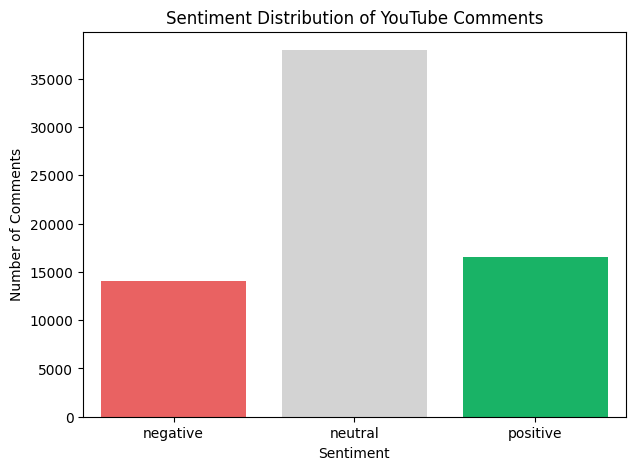

In [8]:
plt.figure(figsize=(7, 5))
sns.countplot(
    data=df,
    x="sentiment_label",
    order=["negative", "neutral", "positive"],
    palette=["#ff4c4c", "#d3d3d3", "#00cc66"]
)
plt.title("Sentiment Distribution of YouTube Comments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

In [10]:
def show_examples(label, n=5):
    print(f"\n{label.upper()} EXAMPLES:")
    print("-" * 60)
    subset = df[df["sentiment_label"] == label].sample(min(n, len(df[df["sentiment_label"] == label])), random_state=42)
    for _, row in subset.iterrows():
        print(f"• {row['lemma_comment']}")
        
show_examples("positive")
show_examples("negative")
show_examples("neutral")



POSITIVE EXAMPLES:
------------------------------------------------------------
• utsavnagmandal go happen despite desire i'am sure aware go ukraine
• americans lead district columbia rent free washington representative president obviously american people britain war creator fcc control canada samex run lice new york ironically single electronic device fcc canada figure pay slave lock support britain
• get good idea catch wrong party neo nazi nato responsible research issue go year
• nato tank cross ukranian border slaughter civilian idk sound russian
• sure people don understand lol

NEGATIVE EXAMPLES:
------------------------------------------------------------
• tysonreuter yes fake father cry fake cemetery fake body fake child totally propaganda people street hand tie back shoot russian soldier ukraine right
• russia seperate world harsh sanction stop war
• stupid zelenesky
• polyverse nah russia want ukraine join nato cause mean enemy get close russian territory actuality fucking

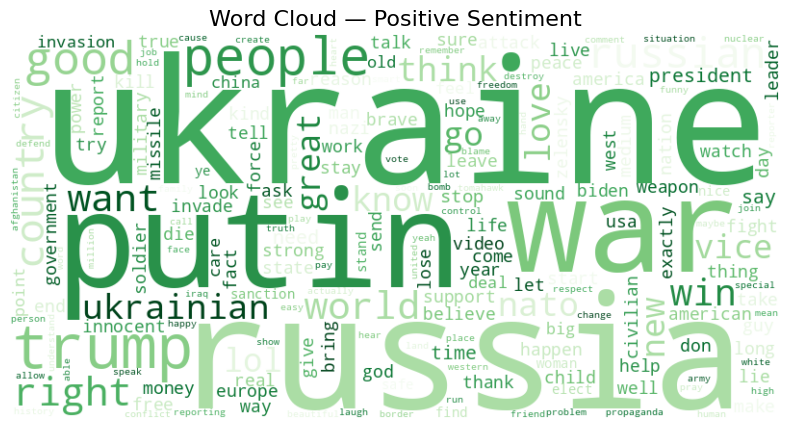

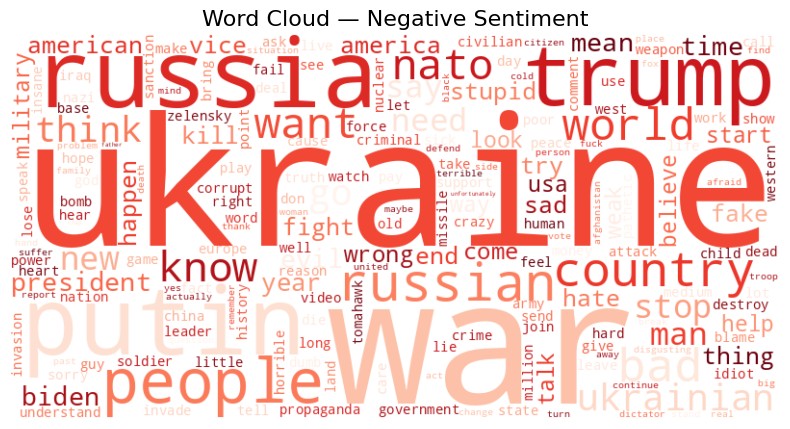

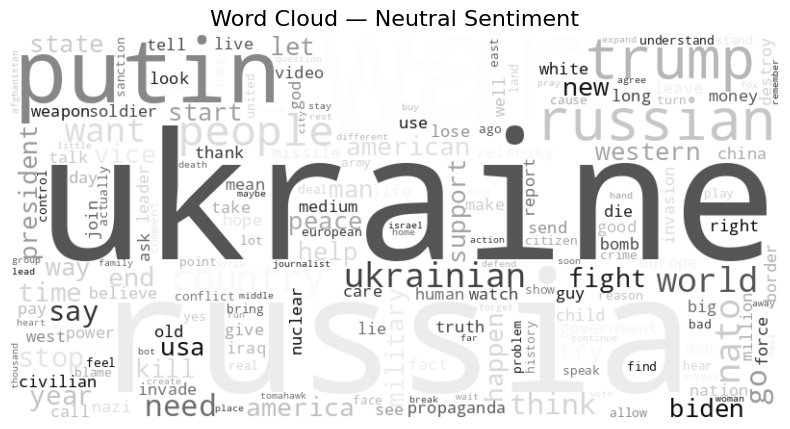

In [16]:
colormaps = {
    "positive": "Greens",
    "negative": "Reds",
    "neutral": "Greys"
}

for label, cmap in colormaps.items():
    subset = df[df["sentiment_label"] == label]["lemma_comment"].dropna().astype(str)
    subset = subset[subset.str.strip() != ""]
    
    text = " ".join(subset.tolist())
    
    if text.strip():
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap=cmap,
            max_words=200,
            collocations=False
        ).generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud — {label.capitalize()} Sentiment", fontsize=16)
        plt.show()
    else:
        print(f"No text available for {label} sentiment.")

In [22]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

Device set to use cpu


In [24]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True
)


def safe_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral"
    text = text[:2000]
    try:
        result = sentiment_model(text, truncation=True)[0]["label"]
        return result.lower()
    except Exception as e:
        return "neutral"

df["sentiment_roberta"] = df["lemma_comment"].progress_apply(safe_sentiment)
df["sentiment_roberta"].value_counts()

Device set to use cpu
100%|██████████| 68557/68557 [24:04<00:00, 47.47it/s]


sentiment_roberta
negative    49691
positive    18651
neutral       215
Name: count, dtype: int64

/tmp/ipykernel_117222/1312691414.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_roberta",


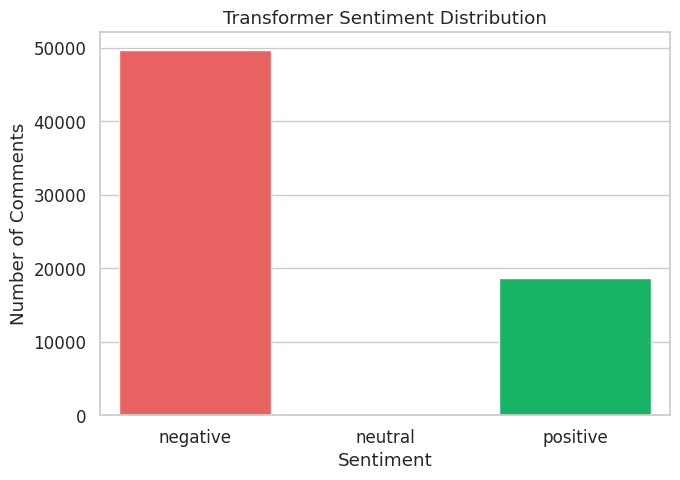

In [25]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x="sentiment_roberta",
              order=["negative", "neutral", "positive"],
              palette=["#ff4c4c", "#d3d3d3", "#00cc66"])
plt.title("Transformer Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

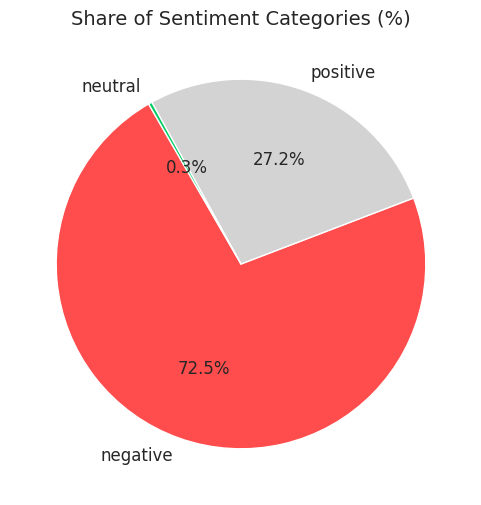

In [27]:
sentiment_counts = df["sentiment_roberta"].value_counts()
sentiment_percent = (sentiment_counts / sentiment_counts.sum() * 100).round(2)

plt.figure(figsize=(6,6))
plt.pie(
    sentiment_percent,
    labels=sentiment_percent.index,
    autopct="%1.1f%%",
    colors=["#ff4c4c", "#d3d3d3", "#00cc66"],
    startangle=120,
    textprops={"fontsize": 12}
)
plt.title("Share of Sentiment Categories (%)", fontsize=14)
plt.show()


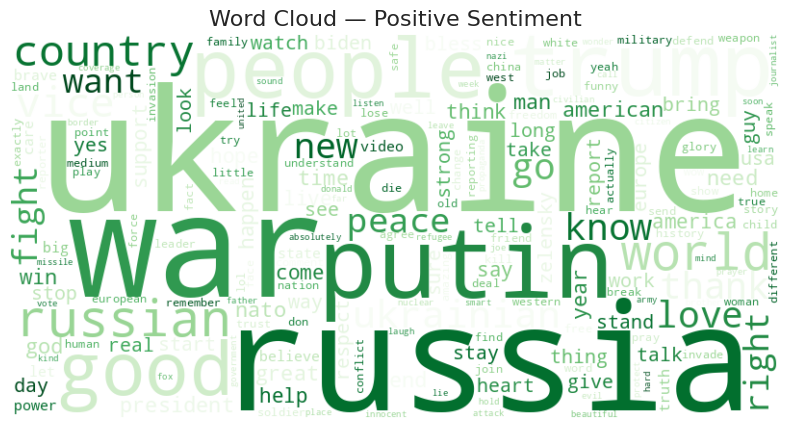

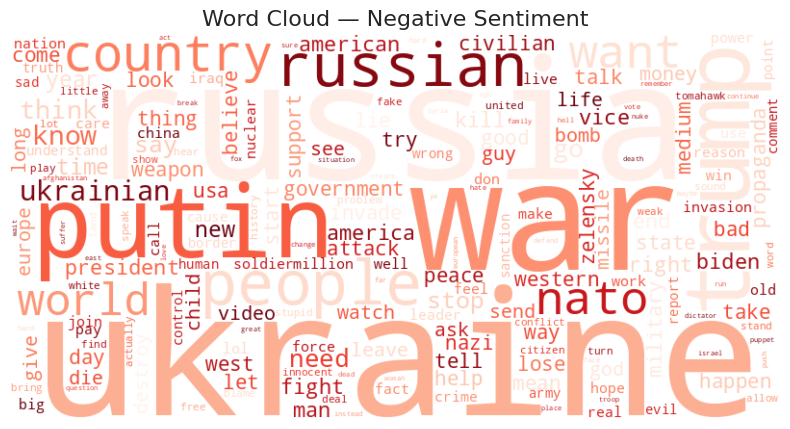

In [29]:
colormaps = {
    "positive": "Greens",
    "negative": "Reds",
    "neutral": "Greys"
}

for label, cmap in colormaps.items():
    subset = df[df["sentiment_roberta"] == label]["lemma_comment"].dropna().astype(str)
    text = " ".join(subset)
    if text.strip():
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap=cmap,
            max_words=200,
            collocations=False
        ).generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud — {label.capitalize()} Sentiment", fontsize=16)
        plt.show()

In [31]:
print("Sentiment distribution:")
print(sentiment_counts)
print("\nSentiment share (%):")
print(sentiment_percent)

Sentiment distribution:
sentiment_roberta
negative    49691
positive    18651
neutral       215
Name: count, dtype: int64

Sentiment share (%):
sentiment_roberta
negative    72.48
positive    27.21
neutral      0.31
Name: count, dtype: float64


In [32]:
def show_examples(label, n=5):
    subset = df[df["sentiment_roberta"] == label]["lemma_comment"].dropna().astype(str)
    subset = subset[subset.str.strip() != ""]
    print(f"\n{label.upper()} EXAMPLES ({min(n, len(subset))} samples):")
    print("-" * 80)
    for comment in subset.sample(min(n, len(subset)), random_state=42):
        print("•", comment)
    print("-" * 80)

show_examples("negative", n=5)
show_examples("neutral", n=5)
show_examples("positive", n=5)


NEGATIVE EXAMPLES (5 samples):
--------------------------------------------------------------------------------
• utter horsesh guy prompt earpiece usual cia need war economy go launch vlad utter tshow people dumb stop breed maybe nuclear war stop selfish percent people support russia explain
• yea msnbc
• yesterday war begin live ukraine europe far away australia hear word word think hear young lifetime make thing feel hollow wish help affect horrible crappy conflict
• happen folk evacuate security
• history ukraine fill deportation exile russification liquidation repression oppression imprisonment famine migration emigration brain drain engender apathy ukrainian today ukrainian hero burn ashe fire history take away secret boundless courage love native land silence impenetrable gley lack faith wait reawakening
--------------------------------------------------------------------------------

NEUTRAL EXAMPLES (0 samples):
----------------------------------------------------------------

In [48]:
labels = ["pro-Ukraine", "pro-Russia", "neutral"]

stance_model = pipeline(
    "zero-shot-classification",
    model="cross-encoder/nli-miniLM2-L6-H768",
    device=-1,
)

sample_df = df.sample(500, random_state=42).copy()
texts = sample_df["lemma_comment"].astype(str).tolist()

batch_size = 8
results = []

for i in tqdm(range(0, len(texts), batch_size),
              desc="Zero-shot stance labeling (fast)",
              ncols=100, mininterval=3):
    batch = texts[i:i + batch_size]
    batch_results = stance_model(
        batch,
        candidate_labels=labels,
        multi_label=False,
        truncation=True
    )
    results.extend(batch_results)

sample_df["stance"] = [r["labels"][0] for r in results]
sample_df[["lemma_comment", "stance"]].head()

Device set to use cpu
Zero-shot stance labeling (fast): 100%|█████████████████████████████| 63/63 [00:41<00:00,  1.53it/s]


,lemma_comment,stance
44856,guy point world keep ignore palestine iraq mal...,neutral
57380,putin call trump attack complain ukraine,pro-Russia
13902,nato war,pro-Russia
16789,think calmly fsb congress woman speak save peo...,pro-Ukraine
9195,main culprit norway,neutral


In [49]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

X_train = embedder.encode(sample_df["lemma_comment"].tolist(), show_progress_bar=True)
y_train = LabelEncoder().fit_transform(sample_df["stance"])

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

print("Classifier trained.")

Batches: 100%|██████████| 16/16 [00:01<00:00, 11.40it/s]


Classifier trained.


In [50]:
X_all = embedder.encode(df["lemma_comment"].astype(str).tolist(), show_progress_bar=True)
preds = clf.predict(X_all)

label_map = {i: lbl for i, lbl in enumerate(LabelEncoder().fit(sample_df["stance"]).classes_)}
df["stance"] = [label_map[p] for p in preds]

Batches: 100%|██████████| 2143/2143 [03:46<00:00,  9.45it/s]


/tmp/ipykernel_117222/2207545364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="stance",


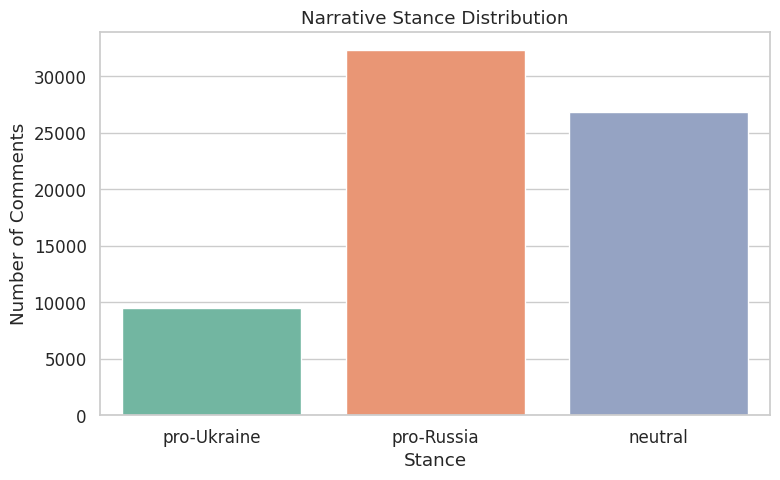

In [51]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="stance",
              order=["pro-Ukraine","pro-Russia","neutral"],
              palette="Set2")
plt.title("Narrative Stance Distribution")
plt.xlabel("Stance")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

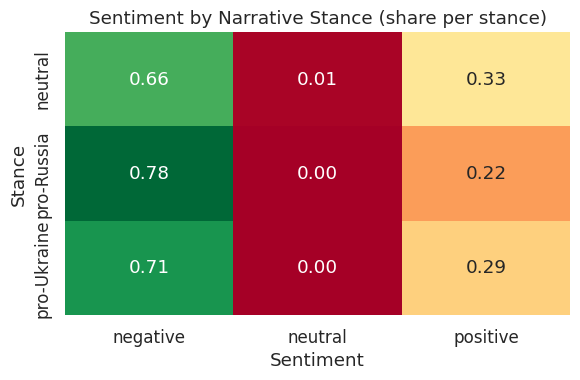

In [52]:
cross_tab = pd.crosstab(df["stance"], df["sentiment_roberta"], normalize="index")
plt.figure(figsize=(6,4))
sns.heatmap(cross_tab, annot=True, cmap="RdYlGn", cbar=False, fmt=".2f")
plt.title("Sentiment by Narrative Stance (share per stance)")
plt.xlabel("Sentiment")
plt.ylabel("Stance")
plt.tight_layout()
plt.show()